# Convert a RGB rendered geotiff BACK into a DEM using the color ramp?

In an attempt to answer [this question](https://www.reddit.com/r/gis/comments/9o6pni/convert_a_rgb_rendered_geotiff_back_into_a_dem/).

First of all, we'll load a rotated version of the image, so that the color bar is exactly vertical

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colorsys

img = plt.imread('hillshade_rotated.png')[:,:]
# remove Alpha layer
img[img[:,:,-1] == 0] = 1
img = img[:,:,:3]

We take a look at the image and find a line to slice through the color bar

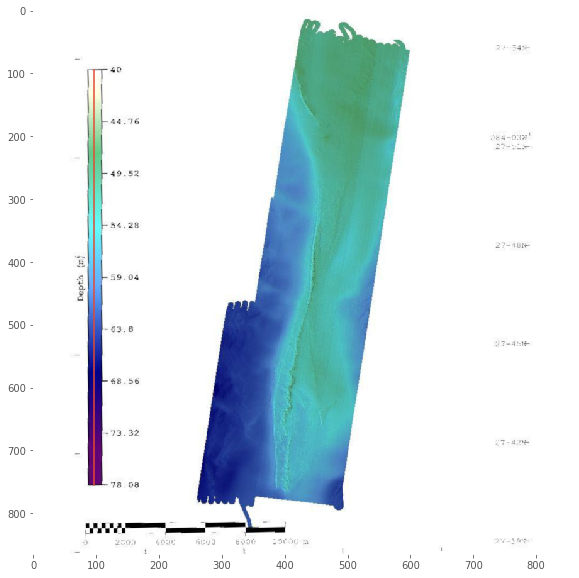

In [2]:
plt.figure(figsize = (10, 10))
plt.grid(None)
plt.imshow(img)
plt.plot([97, 97], [95, 755]);

Extract the colorbar and plot it to verify we extracted the right color data

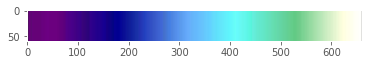

In [3]:
colorbar = img[755:95:-1, 97:98, :]
plt.grid(None)
plt.imshow(np.kron(colorbar, np.ones((1, 60, 1))).transpose(1, 0, 2));

Upon extracting the hue channel from the colorbar data, we see that it is in fact monotonic and close to injective! This means we can reconstruct the original elevation data from just this channel. The blue curve shows that will be some noise towards the ends of the scale.

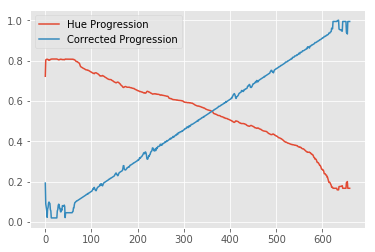

In [4]:
def convert(image):
    fun = np.vectorize(colorsys.rgb_to_hsv)
    return np.stack(fun(image[:,:,0], image[:,:,1], image[:,:,2]))
HUE, SATURATION, VALUE = convert(colorbar)

def correct(x):
    H = np.sort(HUE.reshape(-1))
    return 1 - H.searchsorted(x) / len(H)
    
plt.plot(HUE, label='Hue Progression')
plt.plot(correct(HUE), label='Corrected Progression')
plt.legend();

Using this information, we can calculate the hue channel for the entire image and reconstruct the elevation values. Bear in mind that this is merely an approximation of the original data, as the conversions back-and-forth and the hillshading introduce a lot of noise.

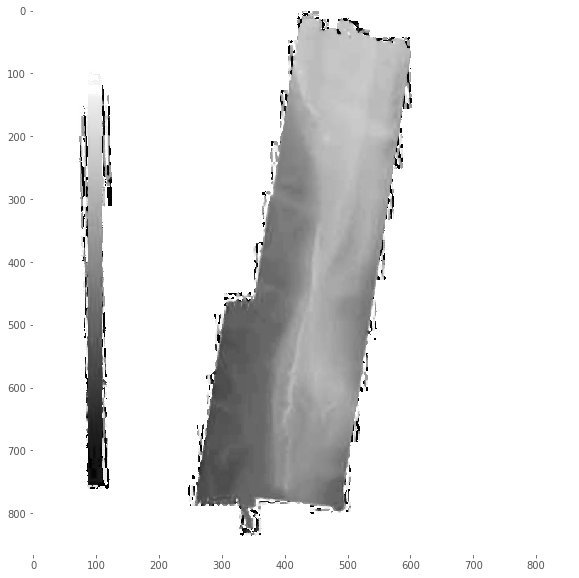

In [5]:
h, s, v = convert(img)
corrected = correct(h)

plt.figure(figsize=(10, 10))
plt.grid(None)
plt.imshow(corrected, cmap='gray')
plt.imsave('elevation_rotated.png', corrected , cmap='gray')

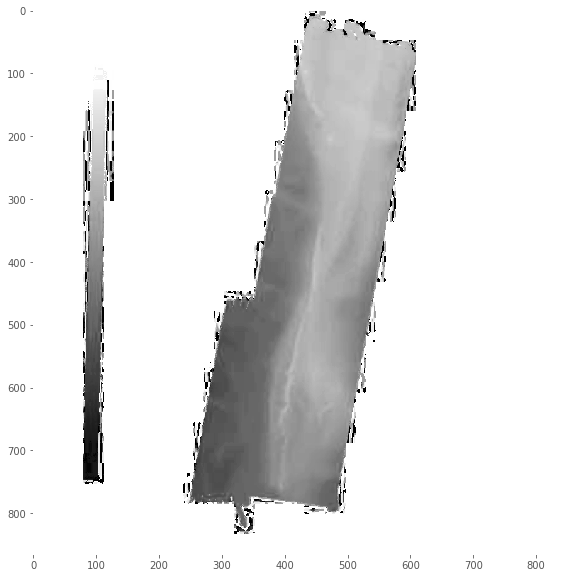

In [6]:
img = plt.imread('hillshade.png')[:,:]
# remove Alpha layer
img[img[:,:,-1] == 0] = 1
img = img[:,:,:3]

h, s, v = convert(img)
corrected = correct(h)

plt.figure(figsize=(10, 10))
plt.grid(None)
plt.imshow(corrected, cmap='gray')
plt.imsave('elevation.png', corrected , cmap='gray')